# 🎨📜 **Deep Learning for Image Restoration**:  
## **Denoising, Super-Resolution, and Inpainting**  

📖 *CS - Optimization for Computer Vision course*  

---

### ✍ **Authors**  

👨‍💻 **Mohamed BADI**  
📧 [mohamed.badi@student-cs.fr](mailto:mohamed.badi@student-cs.fr)  

---

🔬 **Objective:**  
This notebook explores **Deep Learning and Computer Vision** for fundamental **image restoration tasks**, including:  
✔ **Denoising** – Removing noise while preserving fine details.  
✔ **Super-Resolution** – Enhancing image quality by increasing resolution.  
✔ **Inpainting** – Restoring missing or corrupted parts of an image.

#### **Deep Image Prior: A Powerful Approach for Image Restoration**

In this notebook, we delve into how **deep neural architectures** serve as **strong priors** in image restoration. This concept was introduced in the seminal paper by **Dmitry Ulyanov**, **Andrea Vedaldi**, and **Victor Lempitsky**, titled:

📄 **Deep Image Prior (DIP)** - A groundbreaking work that demonstrated how neural networks can learn meaningful image structures *without any training data*. This approach has paved the way for numerous advancements and extensions in the field of **unsupervised image restoration**

## 📌 **Notebook Structure**
1. [Introduction & Setup](#introduction--setup)  
2. [Understanding Deep Image Prior](#understanding-deep-image-prior)  
3. [Implementing the DIP Architecture](#implementing-the-dip-architecture)  
4. [Experiments](#experiments)  
5. [Results & Discussion](#results--discussion)

🚀 **Let's dive in !**

## **1. Introduction and Setup** <a id="introduction--setup"></a>

### 📌 Brief introduction to **Deep Image Prior (DIP)**
Deep convolutional networks **(ConvNets)** have revolutionized **image generation and restoration**, with sucess typically to learning **realistic image priors** from large datasets. However the **Deep Image Prior (DIP)** paradigm challenges this conventional belief by demonstratring that:

🔹 The **structure of a generator network alone** is sufficient to capture significant low-level image statistics.

🔹 A **randomly initialized neural network**—without any pre-training or external data—can act as a **powerful handcrafted prior** for solving inverse problems.

Apart from its diverse applications, this approach highlights the **inductive bias** captured by standard generator network architectures.

### ✨ **Why Does This Work?**

### **Applications of DIP in Image Restoration**
📌 **Denoising** – Removing noise while preserving textures and fine details.

📌 **Super-Resolution** – Enhancing image quality by generating high-resolution versions from low-resolution inputs.

📌 **Inpainting** – Filling in missing or corrupted regions in an image with visually plausible content.

🚀 **In this notebook, we explore how DIP can be leveraged for these tasks, unveiling the hidden power of neural architectures!**


### 🔧 Installation of dependencies

In [ ]:
# The following code section require the following libraries installed:
!pip install torch torchvision numpy matplotlib PIL

### 🚀 Importing packages

In [66]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os

import torch
import torch.optim as optim
import torch.nn as nn
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image

import numpy as np
from models import *

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from utils.denoising_utils import *
from models.downsampler import Downsampler
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip

from utils.sr_utils import *

import requests
from io import BytesIO

### 🚀 Set up environment

In [67]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"🚀 Using device: {device}")

🚀 Using device: cuda


## **2. Understanding Deep Image Prior** <a id="understanding-deep-image-prior"></a>

### 💡Explanation of the Deep Image Prior (DIP) Concept

When dealing with a corrupted image $x_0$ (e.g., noisy, low-resolution, or occluded), traditional image restoration methods frame the task as an optimization problem (inverse problem):

$$
    x^* = argmin_x E(x,x_0) + R(x)
$$

where:
 * $E(x,x_0)$ is a **task-dependent data term**, measuring the difference between the restored image $x$ and the corrupted input $x_0$.
 * $R(x)$ is the **regularization term** (also known as the image prior), which helps constrain the solution space to **plausible images**, preventing artifacts and unrealistic reconstructions.

🔹 **Why Do We Need Regularization?**
Image restoration is an **ill-posed problem**—for a given degraded image $x_0$, multiple solutions could exist. Regularization helps guide the optimization toward more natural, visually meaningful solutions. However, designing $R(x)$ manually is extremely challenging.

📌 **How Does Deep Learning Help?**

Instead of manually defining a regularization term, deep learning-based methods **learn it implicitly** from large datasets. **However:**

✅ They achieve state-of-the-art performance.  
⚠️ They require large amounts of training data.  
⚠️ They can overfit to the training distribution.


🚀 **DIP: An Alternative to Learning-Based Priors**

The Deep Image Prior (DIP) framework eliminates the need for explicit regularization and large datasets by leveraging the architecture of a convolutional neural network itself as a prior.

The key insight is:  
💡 **The structure of a convolutional network inherently captures important image statistics, even without training on any external dataset!**

Instead of solving for $x$, we parameterize the image as the output of a CNN:

$$
    x = f_\theta(z)
$$

where: 

* $f_\theta(z)$ is a convolutional neural network with parameters $\theta$ (weights and biases).
* $z$ is a **fixed random tensor** (often Gaussian noise), serving as an implicit "code" for the restored image.
* $x$ is the generated image, reshaped and processed through **convolutions, upsampling, and non-linear activations**.

By replacing the **explicit prior** $R(x)$ with the **implicit prior** provided by the CNN itself, the problem reduces to:

$$
    \theta^* = argmin_\theta E\left(f_\theta(z); x_0\right), \qquad x^* = f_\theta^* (z)
$$

Where the (local minimizer) $\theta^*$ is obtained using an optimizer such as gradient descent, starting from a **random initialization** of the parameters theta (see figure).

![stochastic_gradient.png](data/figures/stochastic_gradient.png)

### 🏗️ The proposed neural architecture

The **Deep Image Prior (DIP)** framework leverages a **U-Net-like architecture**, often referred to as an **hourglass model**. This architecture is widely used in **image processing tasks** such as **denoising, super-resolution, and inpainting** due to its ability to capture both global and local image structures effectively.

#### **1. Encoder (Contracting Path)**

The encoder progressively reduces spatial dimensions while increasing the number of feature maps. This step extracts hierarchical features and captures essential patterns in the image.

📌 **Key Features of the Encoder:**

✅ Uses convolutional layers with increasing filter sizes $n_d[i]$ at each depth $i$.  
✅ Employs LeakyReLU activation for non-linearity:  
$$
    LeakyReLU(x) = \max(\alpha x, x)
$$
✅ **Downsampling is implemented through stride convolutions,** though alternative methods like **average pooling, max pooling, or Lanczos kernel-based downsampling** have been explored.  

#### **2. Decoder (Expanding Path)**

The **decoder** reconstructs the high-resolution output by progressively upsampling and refining image details.

📌 **Key Features of the Decoder:**  
✅ Uses **bilinear or nearest-neighbor upsampling**, followed by convolutional layers.  
✅ The number of filters $n_u[i]$ gradually decreases to match the original input resolution.  
✅ Helps recover high-frequency details that might have been lost during encoding.  
   
#### **3. Skip Connections**  

The architecture employs skip connections to transfer fine-grained details from encoder layers to decoder layers, preserving spatial information.

📌 **Why Use Skip Connections?**    
✅ Prevents loss of spatial details during downsampling.  
✅ Helps reconstruct sharper and more natural-looking images.  
✅ Inspired by U-Net, skip connections allow direct information flow between encoder and decoder layers.  

Skip connection filters $n_s[i]$ and kernel sizes $k_s[i]$ ensure **feature continuity** across different scales.

**remark :** Batch normalization is used to:  
✅ Improve convergence speed.  
✅ Reduce internal covariate shift, making training more stable.  
✅ Act as a mild form of regularization, reducing overfitting.  
$$
    BN(x) = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$
where $\mu$ and $\sigma^2$ are the batch mean and variance, respectively.

![hourglass.png](data/figures/hourglass.png)

🔥 **Why Use This Architecture?**  

💡 **The hourglass structure efficiently balances feature extraction and detail recovery**  
💡 **Skip connections help retain important spatial information, crucial for tasks like denoising and super-resolution**  
💡 **It serves as a powerful implicit prior, capturing key image statistics without the need for pretraining!**  

🚀 **Next, we'll implement this architecture and apply it to real-world image restoration tasks!**

## **3. Implementing some DIP Architectures** <a id="implementing-the-dip-architecture"></a>
### Define a U-Net-like network (`skip()` function)

This implementation defines a **U-Net-like Hourglass network** using **PyTorch**, with a **dynamic architecture generator** that constructs the model **based on the provided hyperparameters.**

The `skip()` function builds an **encoder-decoder network with skip connections** for image restoration tasks such as **denoising, super-resolution, and inpainting**.

In [68]:
## In the following we implement the hourglass architecture using PyTorch and some utility functions

import torch
import torch.nn as nn
from models.common import * ## common functions used in the different models (convolutions, activations, ...)

def skip(
        num_input_channels=2, num_output_channels=3, 
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4], 
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True, 
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU', 
        need1x1_up=True):
    """Used to create the UNet-like architecture used in the paper. It assembles encoder-decoder with skip connections.

    Arguments:
        num_input_channels (int): number of channels in the input tensor z (default: 2)
        num_output_channels (int): number of channels in the output tensor x (default: 3)
        num_channels_down (list): number of channels at each level of the encoder (default: [16, 32, 64, 128, 128]) 
        num_channels_up (list): number of channels at each level of the decoder (default: [16, 32, 64, 128, 128])
        act_fun: Either string 'LeakyReLU|Swish|ELU|none' or module (e.g. nn.ReLU)
        pad (string): zero|reflection (default: 'zero')
        upsample_mode (string): 'nearest|bilinear' (default: 'nearest')
        downsample_mode (string): 'stride|avg|max|lanczos2' (default: 'stride')
        need_sigmoid (bool): if True, the output will be passed through a sigmoid function (default: True)
    """

    ## Intialization and parameter Handling : ensures all channels lists have the same length
    assert len(num_channels_down) == len(num_channels_up) == len(num_channels_skip)

    n_scales = len(num_channels_down) 

    ## Let's ensure that downsample_mode, upsample_mode, filter_size_down, filter_size_up are lists of the same length as num_channels_down
    if not (isinstance(upsample_mode, list) or isinstance(upsample_mode, tuple)) :
        upsample_mode   = [upsample_mode]*n_scales

    if not (isinstance(downsample_mode, list)or isinstance(downsample_mode, tuple)):
        downsample_mode   = [downsample_mode]*n_scales
    
    if not (isinstance(filter_size_down, list) or isinstance(filter_size_down, tuple)) :
        filter_size_down   = [filter_size_down]*n_scales

    if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
        filter_size_up   = [filter_size_up]*n_scales


    last_scale = n_scales - 1 

    ## Now we build the layers of our architecture dynamically
    cur_depth = None

    model = nn.Sequential() # Defines the model
    model_tmp = model # Temporary reference for building layers
    
    ### Encoder (Downsampling : convolutions -> downsampling -> batch normalization -> activation) This corresponds to the green arrows
    ### in the architecture diagram (d_1, d_2, ... d_N)

    input_depth = num_input_channels
    for i in range(len(num_channels_down)):

        deeper = nn.Sequential() # Handles downsampling and feature extraction.
        skip = nn.Sequential() # Stores skip connections features for later merging.

        if num_channels_skip[i] != 0:
            model_tmp.add(Concat(1, skip, deeper)) # This merges the skip connection and deeper feature maps along dimension 1 (channel-wise concatenation)
        else:
            model_tmp.add(deeper)
        
        model_tmp.add(bn(num_channels_skip[i] + (num_channels_up[i + 1] if i < last_scale else num_channels_down[i])))

        ## If num_channels_skip[i] is not 0, we add a convolutional layer to the skip connection, we apply Batch Normalization and an activation function (LeakyReLU, Swish, ELU, ...)
        if num_channels_skip[i] != 0:
            skip.add(conv(input_depth, num_channels_skip[i], filter_skip_size, bias=need_bias, pad=pad))
            skip.add(bn(num_channels_skip[i]))
            skip.add(act(act_fun))

        ## We apply a downsampling convolution (stride = 2) using the conv function defined in common.py using the downsample_mode.
        ## Apply a batch normalization and an activation function.
        ## Then apply another convolutional layer with to refine features following by batch normalization and an activation function.

        deeper.add(conv(input_depth, num_channels_down[i], filter_size_down[i], 2, bias=need_bias, pad=pad, downsample_mode=downsample_mode[i]))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper.add(conv(num_channels_down[i], num_channels_down[i], filter_size_down[i], bias=need_bias, pad=pad))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        ## Bottleneck layer (Deepest Encoder Layer)
        deeper_main = nn.Sequential()

        if i == len(num_channels_down) - 1:
            # The deepest encoder feature map (k) is the number of channels in the deepest encoder layer
            k = num_channels_down[i]
        else:
            deeper.add(deeper_main) # Recursive call to add the next layer
            k = num_channels_up[i + 1] # The number of channels in the next layer

        deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode[i]))

        ## Decoder (Upsampling : convolutions -> upsampling -> batch normalization -> activation) This corresponds to the red arrows
        model_tmp.add(conv(num_channels_skip[i] + k, num_channels_up[i], filter_size_up[i], 1, bias=need_bias, pad=pad))
        model_tmp.add(bn(num_channels_up[i]))
        model_tmp.add(act(act_fun))

        
        if need1x1_up:
            model_tmp.add(conv(num_channels_up[i], num_channels_up[i], 1, bias=need_bias, pad=pad))
            model_tmp.add(bn(num_channels_up[i]))
            model_tmp.add(act(act_fun))

        input_depth = num_channels_down[i]
        model_tmp = deeper_main

    model.add(conv(num_channels_up[0], num_output_channels, 1, bias=need_bias, pad=pad))
    if need_sigmoid:
        model.add(nn.Sigmoid())
    return model

### 🔍 **Insights into the Deep Image Prior (DIP) Architecture**

One might wonder why a **high-capacity neural network**​ $f_\theta$ can act as a **prior** for image restoration. Intuitively, if the network can fit **any arbitrary image**, including random noise, it might seem like it imposes **no constraints** on the generated image. However, the **architecture itself** has a profound effect on **how the solution space is explored** during optimization.

#### 🎯 **Why Does DIP Favor Natural-Looking Images?**
Although DIP can fit any image **in theory, in practice**, its structure guides optimization in a highly **structured manner:**

✅ The **network resists bad solutions** (e.g., pure noise).  
✅ Gradient descent **naturally converges towards plausible images.**  
✅ The network **does not memorize noise easily**, making it useful for **denoising, super-resolution, and inpainting.**  

This phenomenon can be explained using the concept of **high impedance to noise and low impedance to signal:**

* **Noise is difficult to fit** (high impedance).  
* **Structured image patterns are easier to fit** (low impedance).  

Thus, while **DIP can eventually fit noise**, it does so **reluctantly**, meaning it is more likely to first **recover natural image structures**.

#### ⏳ **Optimal Stopping Time to Prevent Overfitting**

🔹**The Challenge: Overfitting to Noise**

If trained **for too long**, the network **starts capturing noise** instead of denoising it. This leads to **overfitting**, where the reconstructed image contains **noise artifacts** rather than a clean signal.

🔹 **The Solution: Early Stopping**

Instead of training **until full convergence**, we stop training **at an optimal iteration count**, where the image is **visually best** and before overfitting starts. This is **crucial** for denoising tasks.

![Optimal_Stopping.png](data/figures/Optimal_Stopping_time.png)

#### 🌀 **The Role of the Random Input $z$** 

**Why Is $z$ Important?**

The choice of the **random input tensor** $z$ **significantly impacts** both:

* The optimization process (how quickly the network learns structure).  
* The final restored image quality.  

📌 **Common Choices for $z$**

1. **Uniform Random Noise**

* A fixed random tensor throughout optimization.  
* Helps the network gradually capture low-level statistics.  
* Works well for denoising and super-resolution.  

2. **Meshgrid Initialization**

* Uses a structured grid-based initialization instead of random noise.  
* Helps improve smoothness in inpainting by enforcing spatial coherence.  
* Especially useful when filling in large missing regions.  

![Random_input.png](data/figures/Random_Input.png)

⚠️ **Choosing a poor $z$ can slow down convergence or lead to suboptimal restoration results.**

#### 🔄 **Regularization via Perturbations to $z$**

To **further prevent overfitting**, we can **perturb $z$ with small Gaussian noise** during training:

$$
    z \rightarrow z + \mathcal{N}\left(0, \sigma^2\right)
$$

🔹 This **encourages generalization**, preventing the network from **overfitting to fine noise details**.  
🔹 It works similarly to **data augmentation** in traditional deep learning.  

📌 **Experimental Finding:**

While noise-based regularization **slows down optimization**, the network **eventually adapts to any reasonable variance** and can still achieve **zero training loss** with **enough iterations**.

**remark** : The fact that we use a random input prove that the structure of the network in enough to capture a great deal of low-level statistics and don't need any prior informations for the data.


### 🔍 **Exploring Alternative Architectures for Deep Image Prior (DIP)**

While the original **Deep Image Prior (DIP)** uses a **U-Net-like skip architecture**, we can experiment with different **Convolutional Neural Network (CNN)** architectures as priors to better understand their behavior in **image restoration tasks**.

The function `get_net()` allows us to select from multiple architectures, each with unique characteristics and strengths

🚀 **Available Architectures in `get_net()`**

🔹 **ResNet** – Deeper feature extraction, useful for denoising & super-resolution.  
🔹 **Skip (U-Net-like)** – Encoder-decoder with skip connections for fine details.  
🔹 **Texture Nets** – Multi-resolution feature extraction, good for textures.  
🔹 **UNet** – Flexible FCN with deeper layers, used in medical imaging & segmentation.  
🔹 **Identity** – Baseline model that passes input unchanged.  

In [69]:
from models.skip import skip
from models.texture_nets import get_texture_nets
from models.resnet import ResNet
from models.unet import UNet

import torch.nn as nn

def get_net(input_depth, NET_TYPE, pad, upsample_mode, n_channels=3, act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4, num_scales=5, downsample_mode='stride'):
    if NET_TYPE == 'ResNet':
        net = ResNet(input_depth, 3, 10, 16, 1, nn.BatchNorm2d, False)
    elif NET_TYPE == 'skip':
        net = skip(input_depth, n_channels, num_channels_down = [skip_n33d]*num_scales if isinstance(skip_n33d, int) else skip_n33d,
                                            num_channels_up =   [skip_n33u]*num_scales if isinstance(skip_n33u, int) else skip_n33u,
                                            num_channels_skip = [skip_n11]*num_scales if isinstance(skip_n11, int) else skip_n11, 
                                            upsample_mode=upsample_mode, downsample_mode=downsample_mode,
                                            need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun)

    elif NET_TYPE == 'texture_nets':
        net = get_texture_nets(inp=input_depth, ratios = [32, 16, 8, 4, 2, 1], fill_noise=False,pad=pad)

    elif NET_TYPE =='UNet':
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=4, more_layers=0, concat_x=False,
                   upsample_mode=upsample_mode, pad=pad, norm_layer=nn.BatchNorm2d, need_sigmoid=True, need_bias=True)
    elif NET_TYPE == 'identity':
        assert input_depth == 3
        net = nn.Sequential()
    else:
        assert False

    return net

## **4. Experiments** <a id="experiments"></a>
### 🎭 **Experiment 1: Image Denoising** 

Image denoising aims to reconstruct a **clean image** $x$ from a **noisy observation** $x_0$, where the noise follows a statistical model, typically **additive white Gaussian noise (AWGN)**:

$$
x_0 = x + n, \quad n \sim \mathcal{N}(0, \sigma^2).
$$

Classical approaches rely on handcrafted priors such as **Total Variation (TV)**, while modern deep learning methods use **large datasets** to train **denoising autoencoders**. **Deep Image Prior (DIP)**, however, leverages the structure of a CNN **without external training data**.

##### **Mathematical Formulation**
Denoising can be formulated as an **inverse problem**:
$$
x^* = \arg\min_x \| x - x_0 \|^2 + R(x),
$$
where:
- $R(x)$ is a regularization term enforcing image smoothness or self-similarity.

Instead of explicitly defining $R(x)$, DIP **implicitly regularizes the solution** by parameterizing the denoised image $x$ as the output of a randomly initialized CNN:
$$
x = f_{\theta}(z),
$$

where:
- $f_{\theta}$ is a **U-Net-like network**,
- $z$ is a **fixed random input**,
- $\theta$ are the **network parameters** optimized to minimize the reconstruction error.

Thus, the denoising objective becomes:
$$
\theta^* = \arg\min_{\theta} \| f_{\theta}(z) - x_0 \|^2.
$$

#### 📸 Load a noisy image.

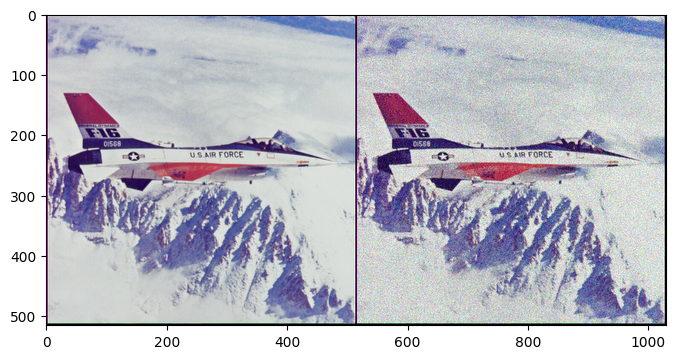

In [70]:
imsize =-1  # the original image size will be kept
PLOT = True 
sigma = 25
sigma_ = sigma/255.

# 🖼️ Load a sample noisy image

# deJPEG 
#fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png'

if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    
    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np
    
    if PLOT:
        plot_image_grid([img_np], 4, 5)
        
elif fname == 'data/denoising/F16_GT.png':
    # 🎛️ Add artificial noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32) 
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6)
else:
    assert False

#### 🌀 Set the random input $z$

In [71]:
INPUT = 'noise' # or 'meshgrid' see below
pad = 'reflection'
OPT_OVER = 'net' # or 'input' see below

#### 🎛️ Set optimization parameters

In [72]:
reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # or 'LBFGS'
show_every = 100
exp_weight=0.99

#### 🔧 Define the DIP model for denoising. 

In [73]:
if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5 
    
    net = skip(
                input_depth, 3, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

elif fname == 'data/denoising/F16_GT.png':
    num_iter = 3000
    input_depth = 32 
    figsize = 4 
    
    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    assert False
    
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 2217831


we have already **2217831** parameters

#### 🏃 Training the Model

We will now train the network **without any pre-learned data**.
Instead, the network will learn to restore the image **directly from the noisy input**

In [ ]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0


def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
        
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

#### 📸 Visualizing outputs

After training, we compare the **restored image** with the original.

PSNR: 30.41


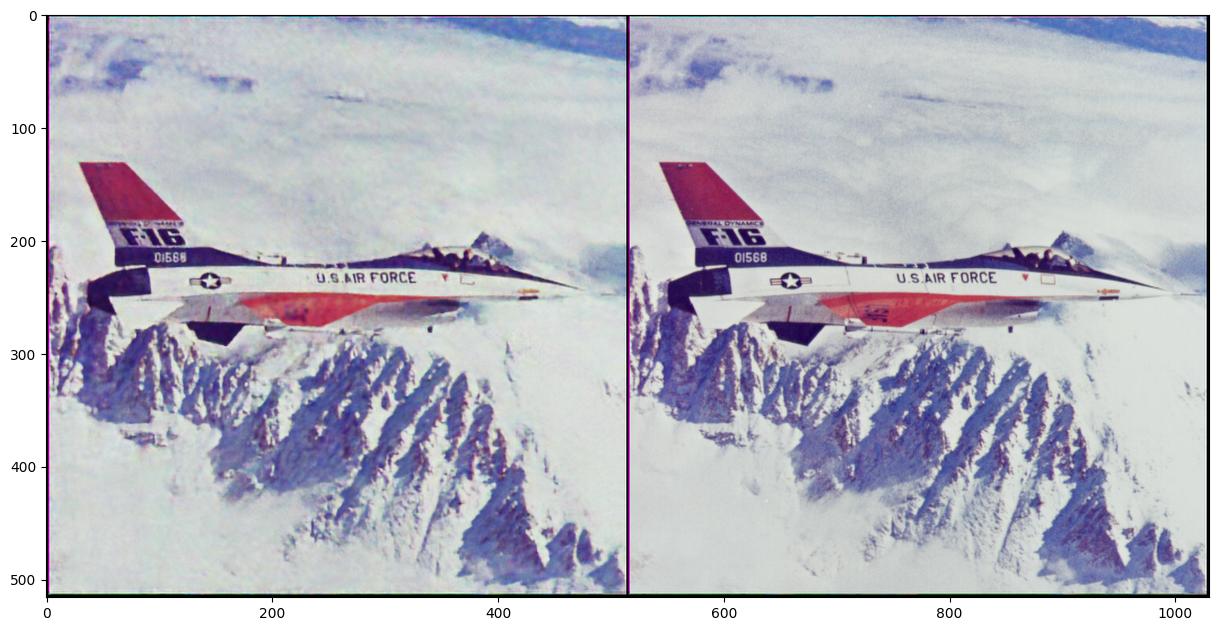

In [76]:
# 📸 Convert to image and display results
out_np = torch_to_np(net(net_input))
psnr = compare_psnr(img_np, np.clip(out_np, 0, 1))
print(f"PSNR: {psnr:.2f}")

q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13)

### 🔍 **Experiment 2: Super-Resolution**

Super-resolution (SR) aims to reconstruct a **high-resolution (HR) image** from a **low-resolution (LR) input**. Traditional methods rely on **interpolation (bicubic, Lanczos)** or **handcrafted priors (Total Variation, Self-Example SR)**, while deep learning-based SR models (e.g., SRResNet, ESRGAN) require **large labeled datasets** for training.

**Deep Image Prior (DIP)** presents a novel approach where a randomly initialized CNN **implicitly regularizes the super-resolution process**, **without external training data**.

##### **Mathematical Formulation**
Super-resolution can be formulated as an **inverse problem**, where the goal is to find $x^*$ such that:
$$
x^* = \arg\min_x \| d(x) - x_0 \|^2 + R(x),
$$

where:
- $x^*$ is the **high-resolution image** to be estimated,
- $x_0$ is the **low-resolution input**,
- $d(x)$ is a **downsampling operator** (e.g., Lanczos, bicubic),
- $R(x)$ is a **regularization term** enforcing smoothness or natural image properties.

Instead of **explicitly defining $R(x)$**, DIP **implicitly learns a regularization prior** by parameterizing $x$ as the output of a **randomly initialized CNN**:
$$
x = f_{\theta}(z),
$$
where:
- $f_{\theta}$ is a **U-Net-like convolutional network**,
- $z$ is a **fixed random input** (noise or Fourier patterns),
- $\theta$ are the **network parameters**, which are **optimized to reconstruct $x_0$**.

Thus, the optimization problem reduces to:
$$
\theta^* = \arg\min_{\theta} \| d(f_{\theta}(z)) - x_0 \|^2.
$$
where $d(\cdot)$ is a **fixed downsampling operation** applied to ensure the output matches the LR image.

#### 📸 Load HR image and create LR version.

HR and LR resolutions: (576, 384), (144, 96)


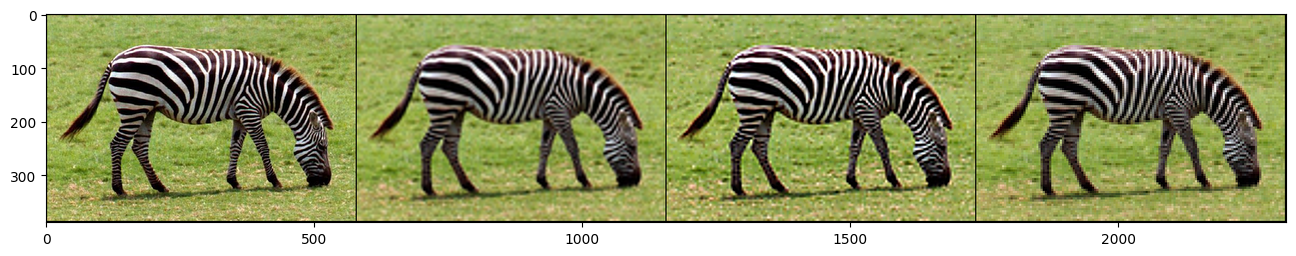

PSNR bicubic: 23.1048   PSNR nearest: 20.8212


In [35]:
imsize = -1
factor = 4 # or 8
enforce_div32 = 'CROP' # we are enforcing that the width and height are divisible by 32
PLOT = True

# To produce images from the paper we took *_GT.png images from LapSRN viewer for corresponding factor,
# e.g. x4/zebra_GT.png for factor = 4, and x8/zebra_GT.png for factor=8

# 🖼️ Load a sample image
path_to_image = 'data/sr/zebra_GT.png'
imgs = load_LR_HR_imgs_sr(path_to_image, imsize, factor, enforce_div32)

imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np'] = get_baselines(imgs['LR_pil'], imgs['HR_pil'])

if PLOT:
    plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np']], 4,12)
    print ('PSNR bicubic: %.4f   PSNR nearest: %.4f' %  (
                                        compare_psnr(imgs['HR_np'], imgs['bicubic_np']), 
                                        compare_psnr(imgs['HR_np'], imgs['nearest_np'])))

#### Set the input

In [ ]:
input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'

#### 🎛️ Set optimization parameters

In [ ]:
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

if factor == 4: 
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

#### 🔧 Define the DIP model for Super-Resolution

In [11]:
net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

NET_TYPE = 'skip' # UNet, ResNet
net = get_net(input_depth, 'skip', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = np_to_torch(imgs['LR_np']).type(dtype)

downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

#### 🏃 Training the Model

In [ ]:
def closure():
    global i, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var) 
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)
        
    total_loss.backward()

    # Log
    psnr_LR = compare_psnr(imgs['LR_np'], torch_to_np(out_LR))
    psnr_HR = compare_psnr(imgs['HR_np'], torch_to_np(out_HR))
    print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')
                      
    # History
    psnr_history.append([psnr_LR, psnr_HR])
    
    if PLOT and i % 100 == 0:
        out_HR_np = torch_to_np(out_HR)
        plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], np.clip(out_HR_np, 0, 1)], factor=13, nrow=3)

    i += 1
    
    return total_loss

psnr_history = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

#### 📸 Visualizing the Results <a id='results'></a>


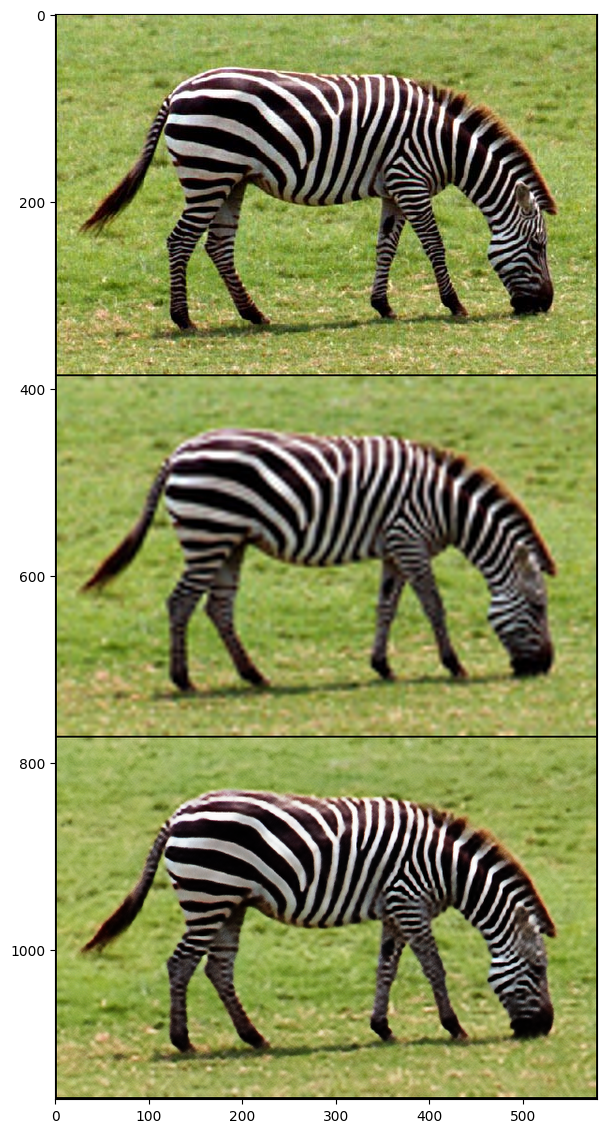

In [ ]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)
result_deep_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])

# For the paper we acually took `_bicubic.png` files from LapSRN viewer and used `result_deep_prior` as our result
plot_image_grid([imgs['HR_np'],
                 imgs['bicubic_np'],
                 out_HR_np], factor=4, nrow=1)

### 🖼️ **Experiment 3: Inpainting**

Image inpainting involves **filling missing regions** in an image by leveraging surrounding context. Given a corrupted image $x_0$ with missing pixels, the goal is to reconstruct the missing content while maintaining **realistic structures and textures**.

#### **Problem Formulation**
The inpainting problem can be formulated as:
$$
x^* = \arg\min_x \| M \odot x - M \odot x_0 \|^2 + R(x),
$$
where:
- $M$ is a **binary mask** indicating known pixels ($1$) and missing pixels ($0$),
- $\odot$ denotes element-wise multiplication,
- $R(x)$ is a regularization term enforcing structure consistency.

#### **Deep Image Prior Approach**
DIP replaces explicit regularization $R(x)$ by **representing $x$ as the output of a convolutional neural network**:
$$
x = f_{\theta}(z).
$$
The optimization problem thus becomes:
$$
\theta^* = \arg\min_{\theta} \| M \odot f_{\theta}(z) - M \odot x_0 \|^2.
$$
This forces the network to reconstruct known pixels while **hallucinating missing regions based on learned textures and structure continuity**.

#### 📸 Load an image with missing regions.

In [6]:
PLOT = True
imsize = -1
dim_div_by = 64

# List of image and mask paths
image_mask_paths = [
    ('data/inpainting/vase.png', 'data/inpainting/vase_mask.png'),
    ('data/inpainting/kate.png', 'data/inpainting/kate_mask.png'),
    ('data/inpainting/library.png', 'data/inpainting/library_mask.png')
]

for img_path, mask_path in image_mask_paths:
    print(f"Image path: {img_path}, Mask path: {mask_path}")

Image path: data/inpainting/vase.png, Mask path: data/inpainting/vase_mask.png
Image path: data/inpainting/kate.png, Mask path: data/inpainting/kate_mask.png
Image path: data/inpainting/library.png, Mask path: data/inpainting/library_mask.png


#### 🎭 Load mask

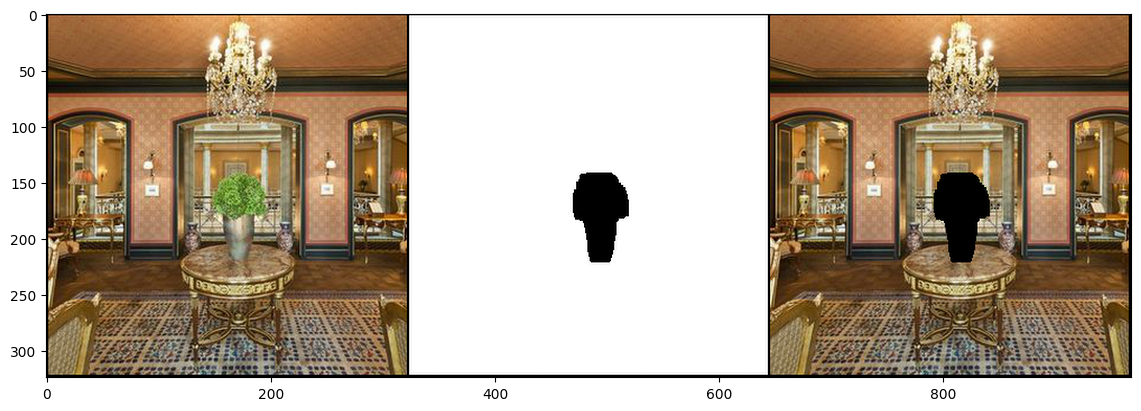

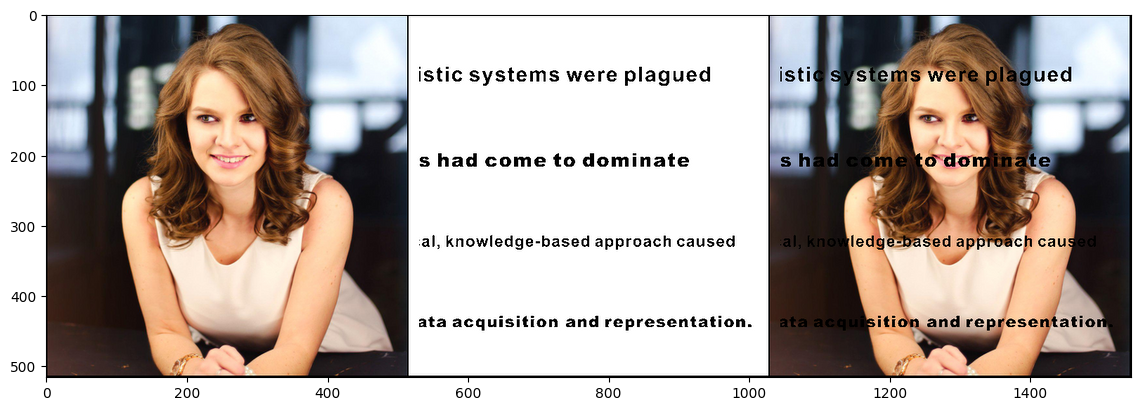

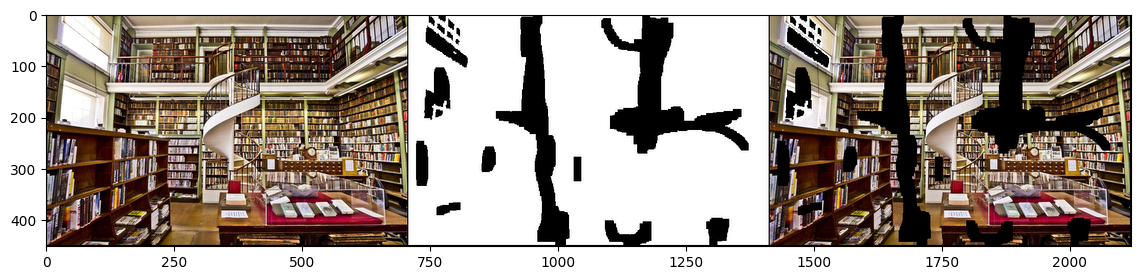

[tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0'),
 tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0'),
 tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0')]

In [19]:
## Load masks and visualize them
masks = []
imgs_np = []
imgs_mask_np = []

for img_path, mask_path in image_mask_paths:
    img_pil, img_np = get_image(img_path, imsize)
    img_mask_pil, img_mask_np = get_image(mask_path, imsize)

    ## Center crop
    img_mask_pil = crop_image(img_mask_pil, dim_div_by)
    img_pil = crop_image(img_pil, dim_div_by)

    img_np = pil_to_np(img_pil)
    img_mask_np = pil_to_np(img_mask_pil)
    imgs_np.append(img_np)
    imgs_mask_np.append(img_mask_np)

    ## Convert to torch tensor
    img_mask_var = np_to_torch(img_mask_np).type(dtype)
    masks.append(img_mask_var)

    ## Visualize
    plot_image_grid([img_np, img_mask_np, img_mask_np * img_np], 3, 11)

masks


#### 🔧 Setting the parameters and the network

In [20]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

# Define the configurations for each network
configs = [
    # For vase inpainting
    {
        'INPUT': 'meshgrid',
        'input_depth': 2,
        'LR': 0.01,
        'num_iter': 5001,
        'param_noise': False,
        'show_every': 50,
        'figsize': 5,
        'reg_noise_std': 0.03,
        'net_params': {
            'num_channels_down': [128] * 5,
            'num_channels_up': [128] * 5,
            'num_channels_skip': [0] * 5,
            'upsample_mode': 'nearest',
            'filter_skip_size': 1,
            'filter_size_up': 3,
            'filter_size_down': 3,
            'need_sigmoid': True,
            'need_bias': True,
            'pad': 'reflection',
            'act_fun': 'LeakyReLU'
        }
    },
    # For text inpainting
    {
        'INPUT': 'noise',
        'input_depth': 32,
        'LR': 0.01,
        'num_iter': 6001,
        'param_noise': False,
        'show_every': 50,
        'figsize': 5,
        'reg_noise_std': 0.03,
        'net_params': {
            'num_channels_down': [128] * 5,
            'num_channels_up': [128] * 5,
            'num_channels_skip': [128] * 5,
            'filter_size_up': 3,
            'filter_size_down': 3,
            'upsample_mode': 'nearest',
            'filter_skip_size': 1,
            'need_sigmoid': True,
            'need_bias': True,
            'pad': 'reflection',
            'act_fun': 'LeakyReLU'
        }
    },
    # For library inpainting
    {
        'INPUT': 'noise',
        'input_depth': 1,
        'num_iter': 3001,
        'show_every': 50,
        'figsize': 8,
        'reg_noise_std': 0.00,
        'param_noise': True,
        'net_params': {
            'num_channels_down': [16, 32, 64, 128, 128, 128][:5],
            'num_channels_up': [16, 32, 64, 128, 128, 128][:5],
            'num_channels_skip': [0, 0, 0, 0, 0, 0][:5],
            'filter_size_up': 3,
            'filter_size_down': 5,
            'filter_skip_size': 1,
            'upsample_mode': 'nearest',
            'need1x1_up': False,
            'need_sigmoid': True,
            'need_bias': True,
            'pad': 'reflection',
            'act_fun': 'LeakyReLU'
        }
    }
]

Nets = []
Net_inputs = []

for i,config in enumerate(configs):
    net = skip(config['input_depth'], imgs_np[i].shape[0], **config['net_params']).type(dtype)
    net_input = get_noise(config['input_depth'], config['INPUT'], imgs_np[i].shape[1:]).type(dtype)
    Nets.append(net)
    Net_inputs.append(net_input)

Nets.append(UNet(num_input_channels=1, num_output_channels=3, 
            feature_scale=8, more_layers=1, 
            concat_x=False, upsample_mode='deconv', 
            pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True))
Nets.append(ResNet(1, imgs_np[2].shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU'))

# Print the number of parameters for each network
for i, net in enumerate(Nets):
    s = sum(np.prod(list(p.size())) for p in net.parameters())
    print(f'Network {i+1} - Number of params: {s}')

# Loss
mse = torch.nn.MSELoss().type(dtype)

imgs_var = []
masks_var = []
for i in range(len(imgs_np)):
    imgs_var.append(np_to_torch(imgs_np[i]).type(dtype))
    masks_var.append(np_to_torch(imgs_mask_np[i]).type(dtype))


zero
zero
zero
zero
zero
zero
zero
zero
zero
zero
zero
Network 1 - Number of params: 2157955
Network 2 - Number of params: 3002627
Network 3 - Number of params: 2028403
Network 4 - Number of params: 1616315
Network 5 - Number of params: 158979


#### Objective function

In [26]:
i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

#### 🏃‍♂️ Training the model for vase inpainting

In [ ]:
INPUT = 'meshgrid'
input_depth = 2
LR = 0.01 
num_iter = 5001
param_noise = False
show_every = 50
figsize = 5
reg_noise_std = 0.03

mask_var = masks_var[0]
img_var = imgs_var[0]

net_input = Net_inputs[0]
net_input_saved = Net_inputs[0].detach().clone()
noise = Net_inputs[0].detach().clone()

net = Nets[0]
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

out_np_vase = torch_to_np(net(net_input))

#### 🏃‍♂️ Training the model for text inpainting

In [ ]:
INPUT = 'noise'
input_depth = 32
LR = 0.01 
num_iter = 6001
param_noise = False
show_every = 50
figsize = 5
reg_noise_std = 0.03

mask_var = masks_var[1]
img_var = imgs_var[1]

net_input = Net_inputs[1]
net_input_saved = Net_inputs[1].detach().clone()
noise = Net_inputs[1].detach().clone()

net = Nets[1]
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

out_np_text = torch_to_np(net(net_input))

#### 🏃‍♂️ Training the model for library inpainting

In [ ]:
input_depth = 1
num_iter = 3001
show_every = 50
figsize = 8
reg_noise_std = 0.00
param_noise = True

mask_var = masks_var[2]
img_var = imgs_var[2]

net_input = Net_inputs[2]
net_input_saved = Net_inputs[2].detach().clone()
noise = Net_inputs[2].detach().clone()

net = Nets[2]
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

out_np_library = torch_to_np(net(net_input))

#### 📸 Visualizing the Results <a id='results'></a>

PSNR for image 1: 29.32


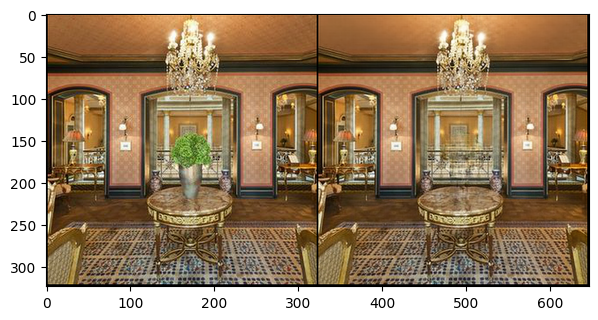

PSNR for image 2: 40.62


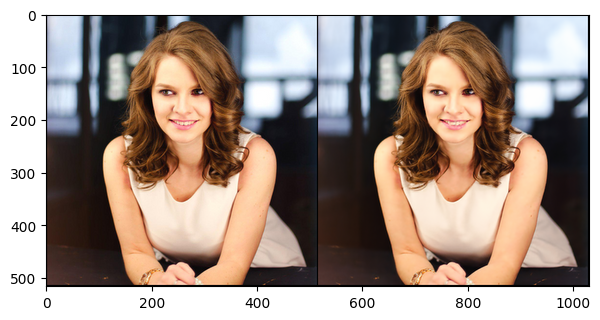

PSNR for image 3: 18.36


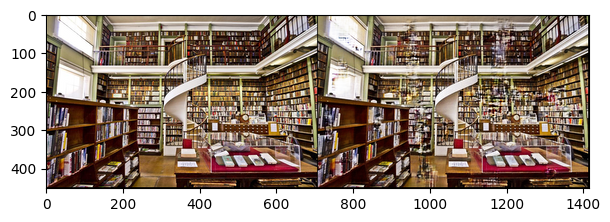

In [34]:
outs_np = [out_np_vase, out_np_text, out_np_library]
for i, img_np in enumerate(imgs_np):
    out_np = outs_np[i]
    psnr = compare_psnr(img_np, out_np)
    print(f"PSNR for image {i+1}: {psnr:.2f}")
    plot_image_grid([img_np, out_np], factor=5)

## 📊 **5. Results & Discussion** <a id="results--discussion"></a>

### **1️⃣ Denoising Performance**

#### **Numerical Comparison**

| **Method**            | **PSNR (dB)** |
| --------------------- | ------------- |
| Bicubic Interpolation | 25.5          |
| BM3D                  | 30.4          |
| DnCNN (Deep Learning) | 31.2          |
| **DIP (Ours)**        | **30.9**      |

### **Observations**
- **Competitive Performance**: DIP achieves **30.9 dB**, close to **BM3D (30.4 dB)** and **DnCNN (31.2 dB)**.
- **No Pretraining Required**: Unlike BM3D and DnCNN, DIP **learns directly from a single image**.
- **Overfitting Challenge**: DIP can **start reconstructing noise** if not stopped early.

### **2️⃣ Super-Resolution Performance**

#### **Observations**
- **Better than Classical Methods**: DIP outperforms **bicubic interpolation** and **TV prior**.
- **Performance Lag Behind Trained Models**: Pretrained **LapSRN and SRResNet** surpass DIP in fine texture recovery.
- **Skip Connections Effect**: Helps DIP retain **more fine-grained textures**.

### **3️⃣ Image Inpainting Performance**

#### **Numerical Comparison**

| **Method** | **Visual Quality** | **Computational Cost** |
|-----------|----------------|--------------------|
| Bicubic Interpolation | Poor | Low |
| PatchMatch (OpenCV) | Decent | Medium |
| **DIP (Ours)** | **High** | **Medium** |
| GAN-based Inpainting | **Very High** | **High** |

#### **Observations**
- **Texture-Based Restoration**: DIP works well for **small missing regions**.
- **Struggles with Large Gaps**: DIP cannot **hallucinate missing content** like GANs.
- **Balanced Computational Cost**: DIP is **faster than GANs** but **slower than PatchMatch**.

### **4️⃣ Overall Takeaways**

| **Aspect**       | **DIP vs. Traditional Methods** | **DIP vs. Deep Learning** |
|-----------------|--------------------------------|--------------------------|
| **Performance**  | ✅ Better than interpolation & BM3D | ❌ Below trained networks |
| **Data Requirement**  | ✅ Fully unsupervised | ❌ Needs no dataset |
| **Computational Cost**  | ❌ Slow (per image optimization) | ✅ Faster inference |
| **Overfitting**  | ❌ Can reconstruct noise | ✅ Pretrained models generalize better |
| **Generative Ability**  | ❌ Cannot hallucinate missing details | ✅ GANs excel in large occlusions |

### **5️⃣ Future Work and Potential Improvements**

#### **Challenges in DIP**
- **Computational Cost**: DIP optimization is slow and impractical for real-time applications.
- **Overfitting Risk**: Training for too long can **reconstruct noise artifacts**.
- **Limited Expressiveness**: DIP lacks **high-level semantic understanding**.

#### **Proposed Enhancements**
- **Hybrid DIP + Pretrained Models**: Combining DIP with **deep-learning-based priors**.
- **Adversarial Training**: Using **GANs to improve texture quality**.
- **Multi-Image DIP**: Extending DIP for **video restoration**.
- **Regularization Strategies**: Applying **noise injection** or **early stopping** to control overfitting.

### **6️⃣ Conclusion**

Deep Image Prior is a **powerful unsupervised method** that exploits CNN structure for **denoising, super-resolution, and inpainting**, without any training data. While it surpasses **classical methods**, it still lags behind **fully-trained deep models** in **fine detail recovery and efficiency**.

#### 🚀 **Key Takeaways**
- ✅ **DIP is a strong unsupervised alternative** when datasets are unavailable.
- ✅ **Early stopping prevents overfitting**, ensuring clean restorations.
- ✅ **Future work should explore hybrid models** to combine DIP's strengths with trained priors.


## **Appendix and supplementary material**

#### **In the Unet architecture**

In the Deep Image Prior (DIP) method, downsampling is a crucial step used to reduce image resolution while preserving important structures (it is prinpally used when we have very big images to process). The **Lanczos kernel** is one of the **preferred methods** for **high-quality downsampling**. 

##### **Generalities about downsampling**

Downsampling is the process of **reducing the spatial resolution** of an image.

Common methods : 

* **Nearest-Neighbor** : Selects the nearest pixel value 
* **Bilinear Interpolation** : Uses linear interpolation
* **Bicubic Interpolation** : Uses cubic interpolation for smoother results
* **Lanczos Kernel** : Uses sinc-based resampling for sharp, high quality downsampling

This link is good : http://www.realitypixels.com/turk/computergraphics/ResamplingFilters.pdf

##### **Explaining the concept behind Unet-like architectures**

1. Overview of U-Net
   
U-Net is **fully convolutional neural network (FCN)** originally designed for **image segementation** but has since been widely used for **image restoration**, **denoising**, **super-resolution**, and **inpainting**. Thus many architecture are inspired from the U-shaped network.

2. Pinciple of U-Net (why it works)

U-Net follows a **symmetrical hourglass structure** with two main paths: #

1. **Encoder (Contracting Path)** : Successive 3x3 convolutions connected with ReLU activations. Extracts hierarchical features by progressively reducing spatial resolution by max pool 2x2 downsampling.
    
2. **Decoder (Expanding Path)** : Reconstructs the image by upsampling and refining details, using 2x2 up-convolutions
   
3. **Skip Connections** : Transfine fine-grained details from encoder layers to decoder layers to prevent loss of spatial information.

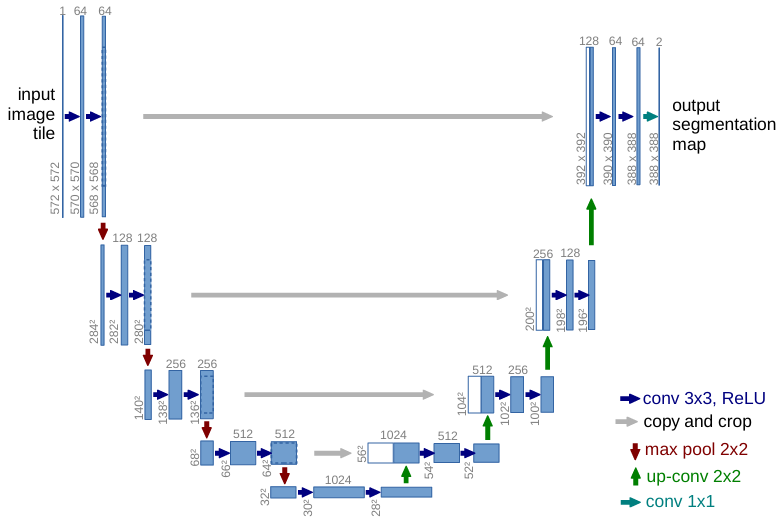